<a href="https://colab.research.google.com/github/M-Pascal/Sound_Clustering/blob/main/Sound_Clustering_assignment_%5BPascal_M%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clustering Unlabeled Sound Data**

## Assignment
The **purpose of this assignment** is to apply clustering techniques to an unlabeled sound dataset and evaluate their effectiveness. Which is going to helps us understand better the role of `dimensionality reduction` through visualizition and improving clustering. And also comparing K-Means and DBSCAN using both metrics and visual interpretations.


# Importing Libraries

In [1]:
# Import all necessary library from here
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from mpl_toolkits.mplot3d import Axes3D

# Setting default Seaborn style for clean plots
sns.set(style='whitegrid')

In [2]:
# Connecting drive to notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setting dataset Path




In [3]:
# Extracted data
PATH = "/content/drive/MyDrive/Y3_T2/Formative/Sound_Clustering/unlabelled_sounds"

# Load the Data
unlabelled_data_path = PATH


# Feature utilities class and functions

In [4]:
# Define Utility Functions and Class
class SoundFeatureExtractor:
  """
  Extracts features from all .wav files in a our directory
  by computing the mean of their Mel-spectrograms.
  """
  def __init__(self, directory, sr=22050, n_mels=128):
      self.directory = directory
      self.sr = sr
      self.n_mels = n_mels

  def extract_features(self):
      features, filenames = [], []
      for file in os.listdir(self.directory):
          if file.endswith('.wav'):
              # Load the audio file
              y, sr = librosa.load(os.path.join(self.directory, file), sr=self.sr)
              # Extract Mel Spectrogram
              mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=self.n_mels)
              mel_db = librosa.power_to_db(mel, ref=np.max)
              # Use the mean across time to reduce dimensionality
              features.append(np.mean(mel_db, axis=1))
              filenames.append(file)
      return np.array(features), filenames


def apply_pca(data, components=3):
  """Applies PCA to reduce feature dimensions."""
  pca = PCA(n_components=components)
  return pca.fit_transform(data), pca



def apply_tsne(data, components=3, perplexity=30):
  """Applies t-SNE to reduce feature dimensions non-linearly."""
  tsne = TSNE(n_components=components, perplexity=perplexity, learning_rate=200, random_state=42)
  return tsne.fit_transform(data)



def plot_3d(data, title='3D Plot', labels=None):
  """Creates a 3D scatter plot from 3D-reduced data (e.g., PCA or t-SNE)."""
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')
  if labels is not None:
      ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='Spectral', s=20)
  else:
      ax.scatter(data[:, 0], data[:, 1], data[:, 2], s=20)
  ax.set_title(title)
  plt.show()

# Dimensionality reduction

In [5]:
# Preprocessing the Dataset using Func.
extractor = SoundFeatureExtractor(unlabelled_data_path)
features, filenames = extractor.extract_features()

In [6]:
# Normalize features to mean=0 and std=1
scaler = StandardScaler()
features_array = scaler.fit_transform(features)

# Visualization Without Dimensionality Reduction
So with experimenting the different visualizations before applying dimensionality reduction will help us to, understand the structure, spread, and relationships within the raw data, Detect redundancy or dominant features; Identify whether clusters or patterns are visible without reducing dimensions, and also to justify the reason why we need the dimensionality reduction based on real visual limitations.

### 1. Scatter plot of raw feature

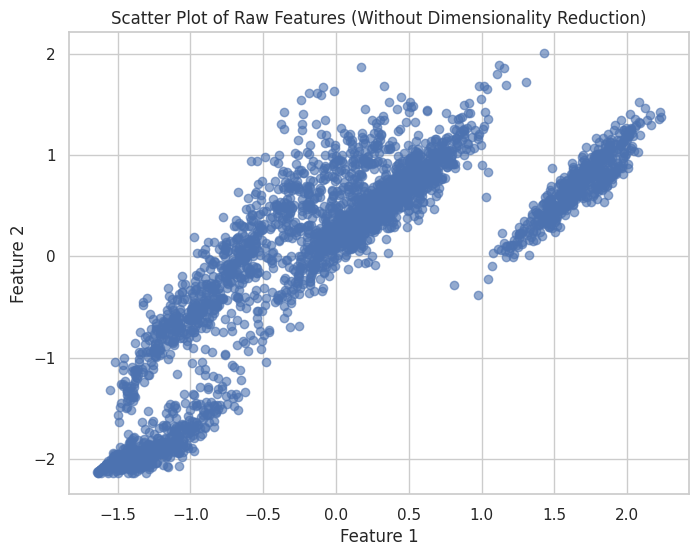

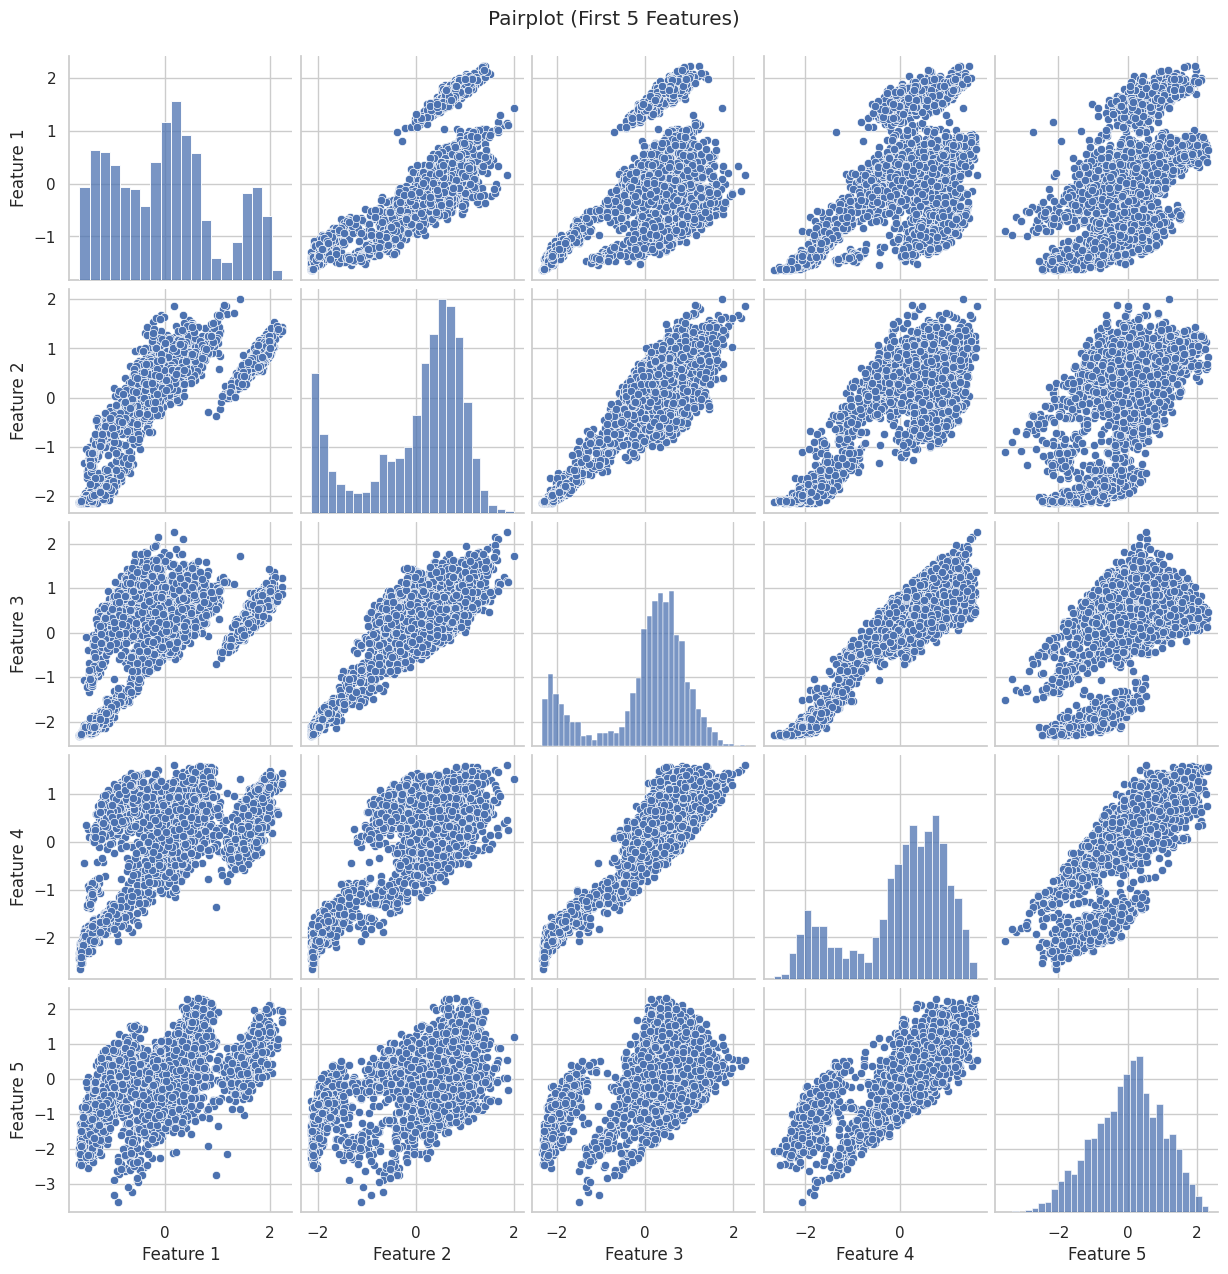

In [7]:

# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(features_array[:, 0], features_array[:, 1], alpha=0.6)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()


### 2. Pair Plot with first 5 features

In [ ]:
# Pair plot (Only using first 5 features)
df = pd.DataFrame(features_array[:, :5], columns=[f"Feature {i+1}" for i in range(5)])
sns.pairplot(df)
plt.suptitle("Pairplot (First 5 Features)", y=1.02)
plt.show()

### 3. Feature Correlation Heatmap

In [ ]:
# Create a DataFrame from standardized features
df_corr = pd.DataFrame(features_array, columns=[f"F{i}" for i in range(features_array.shape[1])])

# Compute and visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Features")
plt.xlabel("Features")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


### 4. Box Plot of Feature Distributions

In [ ]:
# Visualize distributions for the first 10 features
df_box = df_corr.iloc[:, :10]

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_box)
plt.title("Box Plot of First 10 Features")
plt.xlabel("Feature Index")
plt.ylabel("Standardized Value")
plt.tight_layout()
plt.show()


# Dimensionality Reduction (PCA & t-SNE)

### Why is dimensionality reduction is important?
(*Document any challenges/errors from the above experiments.*)

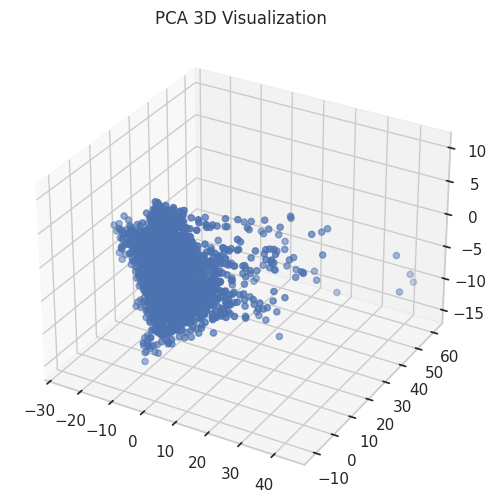

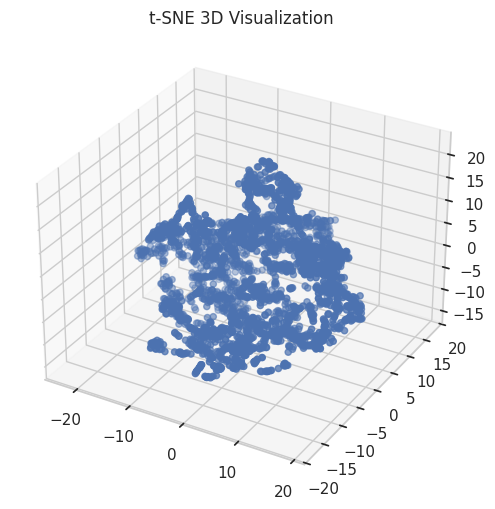

In [8]:

# Apply PCA (3 components)
features_pca, _ = apply_pca(features_array)

# Apply t-SNE (3 components)
features_tsne = apply_tsne(features_array)

# 3D Visualization of reduced features to check natural groupings
plot_3d(features_pca, title='PCA 3D Visualization')
plot_3d(features_tsne, title='t-SNE 3D Visualization')


### Which method (PCA or t-SNE) provides better separability of clusters and why?
(*Write based on your visualizations.*)

# Clustering with K-Means and DBSCAN

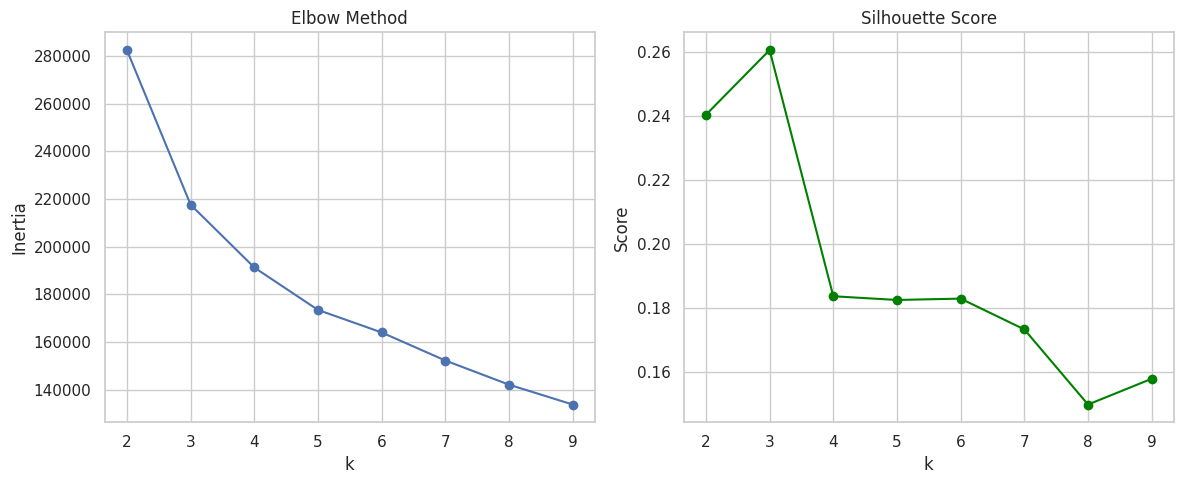

In [9]:

# Optimize number of clusters using Elbow Method and silhoutte score
inertias = []
silhouettes = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features_array)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(features_array, labels))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# plotting elbow method
ax[0].plot(K_range, inertias, marker='o')
ax[0].set_title("Elbow Method")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Inertia")

# Plotting silhouette score
ax[1].plot(K_range, silhouettes, marker='x', color='green')
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Score")
plt.tight_layout()
plt.show()


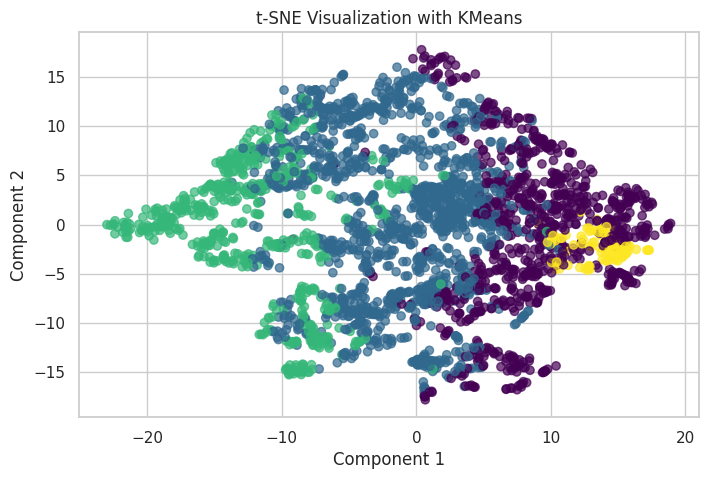

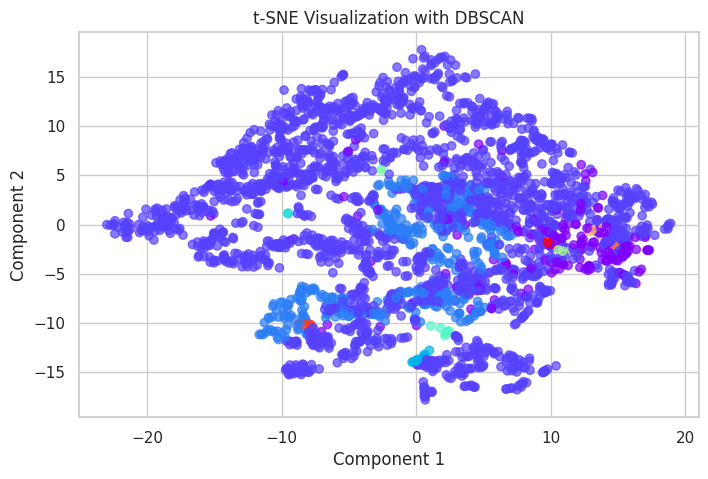

In [10]:

# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 4  # set after reviewing elbow/silhouette plots
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_array)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_array)

In [ ]:
# Scatter Plot for K-Means Clusters
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title("t-SNE Visualization with KMeans")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


In [ ]:
# Scatter Plot for DBSCAN Clusters
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=dbscan_labels, cmap='rainbow', alpha=0.7)
plt.title("t-SNE Visualization with DBSCAN")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


#  Evaluating Clustering Performance.

In [11]:

# Evaluate clustering
kmeans_silhouette = silhouette_score(features_array, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_array, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_array, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_array, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")

K-Means - Silhouette Score: 0.1837, Davies-Bouldin Index: 1.4453
DBSCAN - Silhouette Score: -0.2419, Davies-Bouldin Index: 1.9996


### Discuss the results (max 5 lines)
(*Compare K-Means and DBSCAN performance based on the outputs.*)

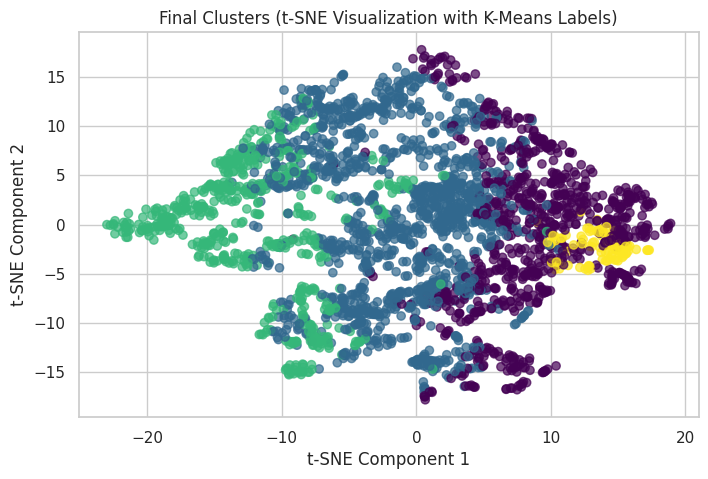

In [12]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.
- Justify why certain clustering methods worked better.
- Relate findings to real-world clustering challenges.

# ------------------------------------------The End------------------------------------------